(160, 320, 3)


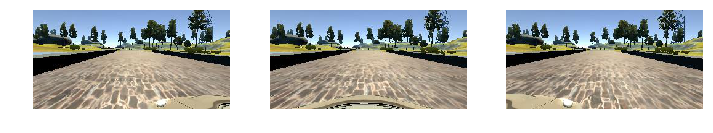

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Explore the sample data 
left = './sample_data/IMG/left_2016_12_01_13_30_48_287.jpg'
center = './sample_data/IMG/center_2016_12_01_13_30_48_287.jpg'
right = './sample_data/IMG/right_2016_12_01_13_30_48_287.jpg'

img1 = plt.imread(left)
img2 = plt.imread(center)
img3 = plt.imread(right)

plt.rcParams['figure.figsize'] = (12, 6)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(img1)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img2)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img3)
plt.axis('off')


print(img1.shape)

### Observations
- The simulator records three images (left, right, center) at a given time
- The steering angle is determined by the edges of the road.
- We can cut off useless information at horizon and the near the car bonnet.
- The left and right camera is nearly parallel

(-0.5, 319.5, 95.5, -0.5)

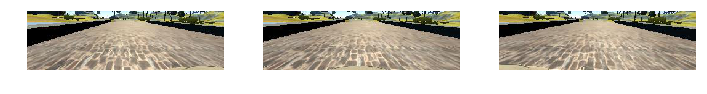

In [3]:
def crop(image, top, bottom):
    """
    Crop an image according to given parmas
    top: percentage of image to be cut from top
    bottom: percentage of image to be cut from bottom
    """
    
    top = int(np.ceil((image.shape[0]*top)))
    bottom = int(np.ceil((image.shape[0]*(1-bottom))))
    
    return image[top:bottom, :]

plt.rcParams['figure.figsize'] = (12, 6)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(crop(img1,0.3,0.1))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(crop(img2,0.3,0.1))
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(crop(img3,0.3,0.1))
plt.axis('off')

In [6]:
img_cop = crop(img1,0.33,0.1)
print(img_cop.shape)

(91, 320, 3)


In [3]:
import pandas as pd

DIR_LOG = './data/driving_log.csv'
data_log = pd.read_csv(DIR_LOG, usecols=[0,1,2,3])
data_log.describe(include='all')

,center,left,right,steering
count,8036,8036,8036,8036.000000
unique,8036,8036,8036,NaN
top,IMG/center_2016_12_01_13_46_32_136.jpg,IMG/left_2016_12_01_13_34_48_074.jpg,IMG/right_2016_12_01_13_34_04_731.jpg,NaN
freq,1,1,1,NaN
mean,NaN,NaN,NaN,0.004070
std,NaN,NaN,NaN,0.128840
min,NaN,NaN,NaN,-0.942695
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1486acdd8>]], dtype=object)

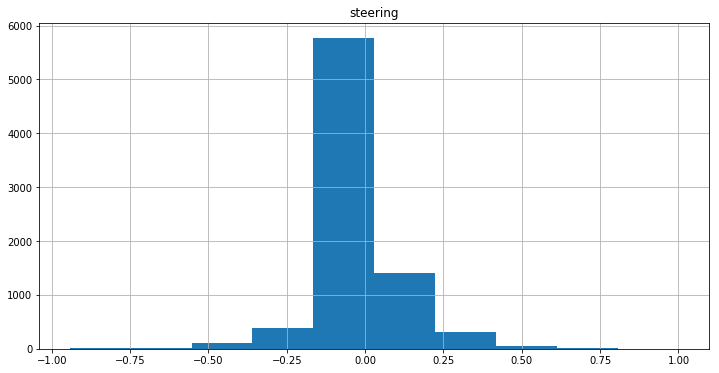

In [4]:
data_log.hist(column='steering')

### Oberservation
1. Total training dataset is 8036*3 => steering
2. Most steering angles are negative (left turn)
3. Data inbalance in the training dataset

### What should we do ?

1. Augment jitter data like Project II: brightness, rotation, shearing
2. Add personal recording data 
3. The first track contains lots of left turns. In order to generalization, we should generate data for right turn 

In [5]:
import cv2

def augment_brightness(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = 0.25 + np.random.uniform() #(0.25-1.25)
    image[:,:,2] = image[:,:,2]*random_bright
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    return image

def flip(image):
    return cv2.flip(image,1) # After vertical flip, the steering angle is negated.


def shear(image, steering_angle, shear_range=200):
  
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return {'image': image, 'steering_angle':steering_angle}

from scipy.ndimage import rotate

def rotation(image, steering_angle, rotation_amount=15):

    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    rad = (np.pi / 180.0) * angle
    return {'image': rotate(image, angle, reshape=False), 'steering_angle': steering_angle + (-1) * rad}

def trans(image,steer,trans_range):
    # Translation
    rows = image.shape[0]
    cols = image.shape[1]
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return {'image':image_tr,'steering_angle':steer_ang}

# Add random shadow
def shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]

    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)

    return image

### Training recovery

- As mentioned in the Introduction of project, we neeed to teach the car what to do when it's off the side of track. It is suggested to record the data when the car is driving from the side of the road back toward the center line. However it is really hard to drive a car just right to recover. 

- Inspired by the post <a https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.ug5va24en>here</a>, We can simulate the recovery events synthetically. Recovery events were simulated by distorting and croping the recorded camera images and ajusting the steering angle.

- Using left and right camera images to simulate the effect of car wandering off to the side, and recovering. We will add a small angle .25 to the left camera and subtract a small angle of 0.25 from the right camera. The main idea being the left camera has to move right to get to center, and right camera has to move left.


In [6]:
# Simulator "extreme angle recovery" 

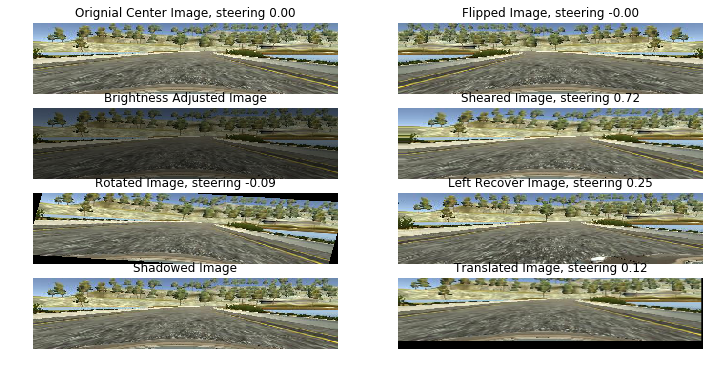

In [8]:
# Example
from keras.preprocessing.image import img_to_array, load_img

row = data_log.iloc[200]
steering = row['steering']
image = load_img('./data/'+row['center'].strip())
image = img_to_array(image).astype(np.uint8)

plt.subplot(4,2,1)
plt.imshow(image, aspect='auto')
plt.axis('off')
plt.title("Orignial Center Image, steering %.2f" % steering)

plt.subplot(4,2,2)
plt.imshow(flip(image), aspect='auto')
plt.axis('off')
plt.title("Flipped Image, steering %.2f" % (-1.0*steering))


plt.subplot(4,2,3)
plt.imshow(augment_brightness(image), aspect='auto')
plt.axis('off')
plt.title("Brightness Adjusted Image")


plt.subplot(4,2,4)
plt.imshow(shear(image, steering)['image'], aspect='auto')
plt.axis('off')
plt.title("Sheared Image, steering %.2f" %(shear(image, steering)['steering_angle']))

plt.subplot(4,2,5)
plt.imshow(rotation(image, steering)['image'], aspect='auto')
plt.axis('off')
plt.title("Rotated Image, steering %.2f" %(rotation(image, steering)['steering_angle']))


left = load_img('./data/'+row["left"].strip())
left = img_to_array(left).astype(np.uint8)
plt.subplot(4,2,6)
plt.imshow(left, aspect='auto')
plt.axis('off')
plt.title("Left Recover Image, steering %.2f" % (steering + 0.25))


plt.subplot(4,2,7)
plt.imshow(shadow(image), aspect='auto')
plt.axis('off')
plt.title("Shadowed Image")

plt.subplot(4,2,8)
plt.imshow(trans(image, steering, 15)['image'], aspect='auto')
plt.axis('off')
plt.title("Translated Image, steering %.2f" %(trans(image, steering,15)['steering_angle']))

### Conclusions:
- Considering the simulator we applied the following augmentation techniques: translation, flip, brightness and recovery synthsis in our case